# I. Imports preliminari

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from zipfile import ZipFile
import os
import sys
import numpy as np
import tensorflow as tf
from keras import layers, models, metrics, losses, callbacks, optimizers
import matplotlib.pyplot as plt
import cv2
import glob
from math import log

Estrazione del construction set preprocessato da cartella zippata

In [3]:
zip_file_path="/content/drive/MyDrive/EIMproject/RETINA/Pre_process_Tomaso_original.zip"
destination_folder="/content/RETINA_train"
import zipfile
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(destination_folder)

Estrazione del test set preprocessato da cartella zippata

In [4]:
zip_file_path="/content/drive/MyDrive/EIMproject/RETINA/pre_process_Tomaso_Kaggle.zip"
destination_folder="/content/RETINA_test"
import zipfile
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(destination_folder)

# II. Carica Dataset #

In [5]:
#Construction set
train_images_files = sorted(glob.glob('/content/RETINA_train/pre_process_TOMASO/*.png'))
train_masks_files = sorted(glob.glob('/content/RETINA_train/Ground truth/*.png'))
#lettura immagini
train_images = np.array([cv2.imread(file_name, cv2.IMREAD_GRAYSCALE) for file_name in train_images_files])
train_masks = np.array([cv2.resize(cv2.imread(file_name, cv2.IMREAD_GRAYSCALE),(512, 512)) for file_name in train_masks_files])    #omologazione dimensioni
x_train = train_images / 255.0                       #conversione a formato float
y_train = train_masks / 255.0
print('Construction set shape:',  x_train.shape)
print('Construction set shape:', y_train.shape)

x_train=np.expand_dims(x_train, axis=-1)
print(x_train.shape)

#Test set
test_images_files = sorted(glob.glob('/content/RETINA_test/pre_process_Tomaso_Kaggle/*.png'))
test_masks_files = sorted(glob.glob('/content/RETINA_test/mask/*.png'))
test_images = np.array([cv2.imread(file_name, cv2.IMREAD_GRAYSCALE) for file_name in test_images_files])
test_masks = np.array([cv2.resize(cv2.imread(file_name, cv2.IMREAD_GRAYSCALE),(512, 512)) for file_name in test_masks_files])      #omologazione dimensioni
x_test = test_images / 255.0                        #conversione a formato float
y_test = test_masks / 255.0

print('Test images shape:',  x_test.shape)
print('Test masks shape:', y_test.shape)

x_test=np.expand_dims(x_test, axis=-1)
print(x_test.shape)

Construction set shape: (600, 512, 512)
Construction set shape: (600, 512, 512)
(600, 512, 512, 1)
Test images shape: (80, 512, 512)
Test masks shape: (80, 512, 512)
(80, 512, 512, 1)


# III. Creazione metriche #

In [6]:
#Converte i valori sopra la treshold a 1, gli altri a zero
def digitize(y, treshold=0.5):
  return tf.cast(tf.greater_equal(y, treshold), tf.float32)

def IoU(y_true, y_pred):                                # Utilizzata per valutare la rete
  y_true = digitize(y_true)
  y_pred = digitize(y_pred)
  intersection = tf.multiply(y_true, y_pred)
  suminter = tf.reduce_sum(intersection)
  return suminter / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - suminter)

def dice_coefficient(y_true, y_pred):                   # Utilizzata per valutare la rete
  y_true = digitize(y_true)
  y_pred = digitize(y_pred)
  intersection = tf.multiply(y_true, y_pred)
  suminter = tf.reduce_sum(intersection)
  return 2 * suminter / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred))


# IV Data-augmentation  #

In [7]:

def crop(x, y, crop_size=64):
  #Croppa un'area dell'immagine casuale
  #Input:
  #  x = immagine
  #  y = ground truth
  #  crop_size = dimenzione della patch
  #Output:
  #  x = patch selezionata sull'immagine
  #  y = patch selezionata sulla maschera

  start_x = np.random.randint(0, x.shape[0] - crop_size)
  start_y = np.random.randint(0, x.shape[1] - crop_size)

  x = x[start_x:start_x+crop_size, start_y:start_y+crop_size, :]
  y = y[start_x:start_x+crop_size, start_y:start_y+crop_size]

  return x, y


def flip(x, y):
  #"Flippa" randomicamnete su gli assi
  #Input:
  #  x = immagine
  #  y = ground truth

  #Output:
  #  x = immagine flippata
  #  y = maschera flippata

 #estrazione di un numero casuale
  flip_type = np.random.randint(0, 3)
 #sulla base del risultato si attiva uno dei seguenti casi
  match(flip_type):
    case 0: #  flip orizzontale
      x = x[::-1, :, :]
      y = y[::-1, :]
      return x, y
    case 1: # flip verticale
      x = x[:, ::-1, :]
      y = y[:, ::-1]
      return x, y
    case 2: # flip orizzontale e  flip verticale
      x = x[::-1, ::-1, :]
      y = y[::-1, ::-1]
      return x, y

#ruota di 90° (Chi l'avrebbe mai detto)
def rotate90(x, y):
  #Ruota di 90° le immagini
  #Input:
  #  x = immagine
  #  y = ground truth

  #Output:
  #  x = immagine ruotata
  #  y = maschera ruotata

  #ruota tante volte quanto il numero estratto
  angle = np.random.randint(1, 4)
  for _ in range(angle):
    x = cv2.rotate(x, cv2.ROTATE_90_CLOCKWISE)
    y = cv2.rotate(y, cv2.ROTATE_90_CLOCKWISE)
  return np.expand_dims(x, axis=-1), y

#Inverte i valori della immagine in ingresso
def invert(x, y):
  #Inverte i valori della immagine in ingresso
  #Input:
  #  x = immagine
  #  y = ground truth

  #Output:
  #  x = immagine invertita
  #  y = ground truth invariata
  return 1-x, y


def noise(x, y):
  #Introduzione di rumore
  #Input:
  #  x = immagine
  #  y = ground truth

  #Output:
  #  x = immagine rumorosa
  #  y = ground truth invariata
  noise = 0.08 * np.random.rand(*x.shape)

  return np.clip(x+noise, 0, 1), y


def random_square(x, y, size=8):
  #Applica un quadrato in un punto dell'immagine
  #Input:
  #  x = immagine
  #  y = ground truth
  #  size = dimensione del quadrato da far inserire

  #Output:
  #  x = immagine con quadrato
  #  y = ground truth con quadrato nero nella stessa posizione

  start_x = np.random.randint(0, x.shape[0] - size)
  start_y = np.random.randint(0, x.shape[1] - size)

  #colore scelto randomicamente
  color = np.random.rand(1,)

  x[start_x:start_x+size, start_y:start_y+size, :] = color
  y[start_x:start_x+size, start_y:start_y+size] = 0

  return x, y


def apply_preprocessing(x, y, crop_size=64):
  #applica le trasformazioni con una certa probabilità (sono divise in 3 categorie)
  x = np.copy(x)
  y = np.copy(y)

  x, y = crop(x, y, crop_size)

  x = np.clip(x, 0, 1)

  identity = lambda a, b: (a, b)
#modifica orientamento
  preprocessing_first=[
      identity,
      flip,
      rotate90
  ]
#modifica valori di intensità
  preprocessing_second=[
      identity,
      invert
  ]
#aggiungi variabilità
  preprocessing_last=[
      identity,
      noise,
      (lambda x, y: random_square(x, y, crop_size//4))
  ]
  #probabilità con cuoi avvengono le trasformazioni
  first_prob = [0.34, 0.33, 0.33]
  second_prob = [0.9, 0.1]
  last_prob = [0.8, 0.15, 0.05]

  first_pp = np.random.choice(len(preprocessing_first), 1, p=first_prob)[0]
  x, y = preprocessing_first[first_pp](x, y)
  second_pp = np.random.choice(len(preprocessing_second), 1, p=second_prob)[0]
  x, y = preprocessing_second[second_pp](x, y)
  last_pp = np.random.choice(len(preprocessing_last), 1, p=last_prob)[0]

  return preprocessing_last[last_pp](x, y)

Definizione funzione di generazione batch per keras

In [8]:
def batch_generation(x, y, batch_size, crop_size=96, batch_multiplication=10):
  #Definizione del seed in modo che il validation sia costante
  np.random.seed(1)

  #scelta del validation set con random sampling
  valid_indexes = np.random.choice(len(x), len(x) // 10, replace=False)
  #tutte le restati immagini appartengono al Training set
  train_indexes = [k for k in range(len(x)) if k not in valid_indexes]

  x_train = x[train_indexes]
  y_train = y[train_indexes]
  x_valid = x[valid_indexes]
  y_valid = y[valid_indexes]

 #numero di batch per epoca
  reduced_steps_per_epoch = len(x_train) // batch_size
 #numero di batch post moltiplicazione per epoca
  steps_per_epoch =batch_multiplication * len(x_train) // batch_size

  def batch_generator():
    while True:
      batches = []
      for step in range(reduced_steps_per_epoch):
        low_idx = step * batch_size

        high_idx = min(low_idx+batch_size, len(x_train))

        x_images = x_train[low_idx:high_idx]

        y_masks = y_train[low_idx:high_idx]

        for _ in range(batch_multiplication):
          x_batch = []
          y_batch = []
          for idx in range(len(x_images)):
            #Applicazione della data augmentation
            xpp, ypp = apply_preprocessing(x_images[idx], y_masks[idx], crop_size)

            x_batch.append(xpp)
            y_batch.append(ypp)

          x_batch = np.stack(x_batch, axis=0)
          y_batch = np.stack(y_batch, axis=0)
          batches.append([x_batch, y_batch])

      for step in range(steps_per_epoch):
        yield batches[step][0], batches[step][1]

  return batch_generator, x_valid, y_valid, steps_per_epoch

# V. Creazione del modello #

In [9]:
#Creazione del modello, riferirsi alla relazione per ulteriori dettagli
def create_unet3plus_model(input_shape=(None, None, 1), f0=32, encoder_blocks=4):
  f_lat =   f0 * 2 ** (encoder_blocks+1)         #filtri latent space

  inputs = layers.Input(input_shape)
  x = inputs
  skips = {}               #inizializzazione skip connection

#ENCODING
  for block in range(encoder_blocks):
    f_block = f0 * 2 ** (block+1)                   # filtri di questo blocco
    s = layers.Conv2D(f_block, (3, 3), padding='same', name=f'encoder{block}_conv')(x)
    s = layers.BatchNormalization(name=f'encoder{block}_bn')(s)
    s = layers.Activation('relu', name=f'encoder{block}_activation')(s)
    x = layers.MaxPooling2D((2, 2), name=f'encoder{block}_maxpool')(s)

    skips[f'encoder{block}'] = s
#LATENT SPACE
  lat = layers.Conv2D(f_lat, (1, 1), padding='same', name='latent_pw')(x)
  lat = layers.BatchNormalization(name='latent_bn1')(lat)
  lat = layers.Activation('relu', name='latent_activation1')(lat)
  lat = layers.DepthwiseConv2D((3, 3), padding='same', name='latent_dw')(lat)
  lat = layers.BatchNormalization(name='latent_bn2')(lat)
  lat = layers.Activation('relu', name='latent_activation2')(lat)
#SKIP CONNECTIONS
  for block in range(encoder_blocks-1, -1, -1):
    up = 2 ** (encoder_blocks-block)
    lat_skip = layers.UpSampling2D((up, up), name=f'latent_skip{up}_up')(lat)
    lat_skip = layers.Conv2D(f0*2, (3, 3), padding='same', name=f'latent_skip{up}_conv')(lat_skip)
    lat_skip = layers.BatchNormalization(name=f'latent_skip{up}_bn')(lat_skip)
    lat_skip = layers.Activation('relu', name=f'latent_skip{up}_activation')(lat_skip)
    encoder_skips = []
    for skip in range(block, -1, -1):
      encoder_skip = skips[f'encoder{skip}']
      down = 2 ** (block-skip)
      encoder_skip = layers.MaxPooling2D((down, down), name=f'encoder{skip}_skip{down}_down')(encoder_skip)
      encoder_skip = layers.Conv2D(f0*2, (3, 3), padding='same', name=f'encoder{skip}_skip{down}_conv')(encoder_skip)
      encoder_skip = layers.BatchNormalization(name=f'encoder{skip}_skip{down}_bn')(encoder_skip)
      encoder_skip = layers.Activation('relu', name=f'encoder{skip}_skip{down}_activation')(encoder_skip)
      encoder_skips.append(encoder_skip)
    decoder_skips = []
#DECODING
    for skip in range(block+1, encoder_blocks):
      decoder_skip = skips[f'decoder{skip}']
      up = 2 ** (skip-block)
      decoder_skip = layers.UpSampling2D((up, up), name=f'decoder{skip}_skip{up}_up')(decoder_skip)
      decoder_skip = layers.Conv2D(f0*2, (3, 3), padding='same', name=f'decoder{skip}_skip{up}_conv')(decoder_skip)
      decoder_skip = layers.BatchNormalization(name=f'decoder{skip}_skip{up}_bn')(decoder_skip)
      decoder_skip = layers.Activation('relu', name=f'decoder{skip}_skip{up}_activation')(decoder_skip)
      decoder_skips.append(decoder_skip)
    x = layers.concatenate([lat_skip, *encoder_skips, *decoder_skips], name=f'decoder{block}_concatenate')
    x = layers.Conv2D(f0*2, (3, 3), padding='same', name=f'decoder{block}_conv')(x)
    x = layers.BatchNormalization(name=f'decoder{block}_bn')(x)
    x = layers.Activation('relu', name=f'decoder{block}_activation')(x)
    skips[f'decoder{block}'] = x

  head_conv = layers.Conv2D(f0, (3, 3), padding='same', name='head_conv')
  head_bn = layers.BatchNormalization(name='head_bn')
  head_activ = layers.Activation('relu', name='head_activation')
  head_out = layers.Conv2D(1, (3, 3), padding='same', activation='sigmoid', name='head_conv_out')

#OUTPUT
  outputs = []
  for block in range(encoder_blocks):
    out_block = skips[f'decoder{block}']
    up = 2 ** block
    out_block = layers.UpSampling2D((up, up), name=f'deep_supervision{block}_up', interpolation='bilinear')(out_block)
    out_block = head_conv(out_block)
    out_block = head_bn(out_block)
    out_block = head_activ(out_block)
    out_block = head_out(out_block)
    outputs.append(out_block)

  return models.Model(inputs=inputs, outputs=outputs)

unet3plus_model = create_unet3plus_model()
unet3plus_model.summary(line_length=140)

Model: "model"
____________________________________________________________________________________________________________________________________________
 Layer (type)                             Output Shape                              Param #       Connected to                              
 input_1 (InputLayer)                     [(None, None, None, 1)]                   0             []                                        
                                                                                                                                            
 encoder0_conv (Conv2D)                   (None, None, None, 64)                    640           ['input_1[0][0]']                         
                                                                                                                                            
 encoder0_bn (BatchNormalization)         (None, None, None, 64)                    256           ['encoder0_conv[0][0]']                  

# VI. Train the model #

In [ ]:
#definizione delle loss
def dice_loss(y_true, y_pred, smooth=1):
  intersection = tf.multiply(y_true, y_pred)
  return 1 - (2 * tf.reduce_sum(intersection) + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def iou_loss(y_true, y_pred, smooth=1):
  intersection =  tf.reduce_sum(tf.multiply(y_true, y_pred))
  return 1 - (intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + smooth)

def mae(y_true, y_pred):
  return tf.reduce_mean(tf.abs(y_true - y_pred))

def mse(y_true, y_pred):
  return tf.reduce_mean(tf.square(y_true - y_pred))

def custom_loss(losses, weights):
  def loss(y_true, y_pred):
    value = tf.constant([0.0])
    for l, w in zip(losses, weights):
      value += l(y_true, y_pred) * w
    return value
  return loss

file_name = 'unet3plus_gs_ds.h5'

In [11]:
#definizione della batch size
batch_size = 20

#generazione dei batch del validation
batch_generator, x_valid, y_valid, steps_per_epoch = batch_generation(x_train, y_train, batch_size,
                                                                      batch_multiplication=60)

#Creazione checkpoint
checkpoint = callbacks.ModelCheckpoint(file_name,
                                       monitor='val_head_conv_out_dice_coefficient',
                                       verbose=1,
                                       save_best_only=True,
                                       mode='max')

#Definizione dello schedule delle loss
loss_scheduling = [
    [10, custom_loss([mse, mae], [1, 1])],
    [10, custom_loss([mse, mae, dice_loss, iou_loss], [1, 1, 1, 1])],
    [10, custom_loss([dice_loss, iou_loss], [1, 1])]
]
#learning rate iniziale
learning_rate = 1e-3

#Inizio allenamento
for [epochs, loss] in loss_scheduling:
  unet3plus_model.compile(loss=loss, optimizer='adam', metrics=[metrics.RootMeanSquaredError(),
                                                           metrics.MeanAbsoluteError(),
                                                           IoU,
                                                           dice_coefficient])
  unet3plus_model.fit(batch_generator(), epochs=epochs, steps_per_epoch=steps_per_epoch, validation_data=(x_valid, y_valid),
                      validation_batch_size=1, callbacks=[checkpoint])

Epoch 1/10
 189/1620 [==>...........................] - ETA: 8:48 - loss: 0.5923 - head_conv_out_loss: 0.1292 - head_conv_out_1_loss: 0.1339 - head_conv_out_2_loss: 0.1476 - head_conv_out_3_loss: 0.1816 - head_conv_out_root_mean_squared_error: 0.2174 - head_conv_out_mean_absolute_error: 0.0820 - head_conv_out_IoU: 0.4366 - head_conv_out_dice_coefficient: 0.5942 - head_conv_out_1_root_mean_squared_error: 0.2193 - head_conv_out_1_mean_absolute_error: 0.0858 - head_conv_out_1_IoU: 0.4192 - head_conv_out_1_dice_coefficient: 0.5757 - head_conv_out_2_root_mean_squared_error: 0.2292 - head_conv_out_2_mean_absolute_error: 0.0950 - head_conv_out_2_IoU: 0.3611 - head_conv_out_2_dice_coefficient: 0.5118 - head_conv_out_3_root_mean_squared_error: 0.2603 - head_conv_out_3_mean_absolute_error: 0.1138 - head_conv_out_3_IoU: 0.1869 - head_conv_out_3_dice_coefficient: 0.2958

KeyboardInterrupt: 

# VII. Fase di validazione #


1/1 [==============================] - 0s 21ms/step


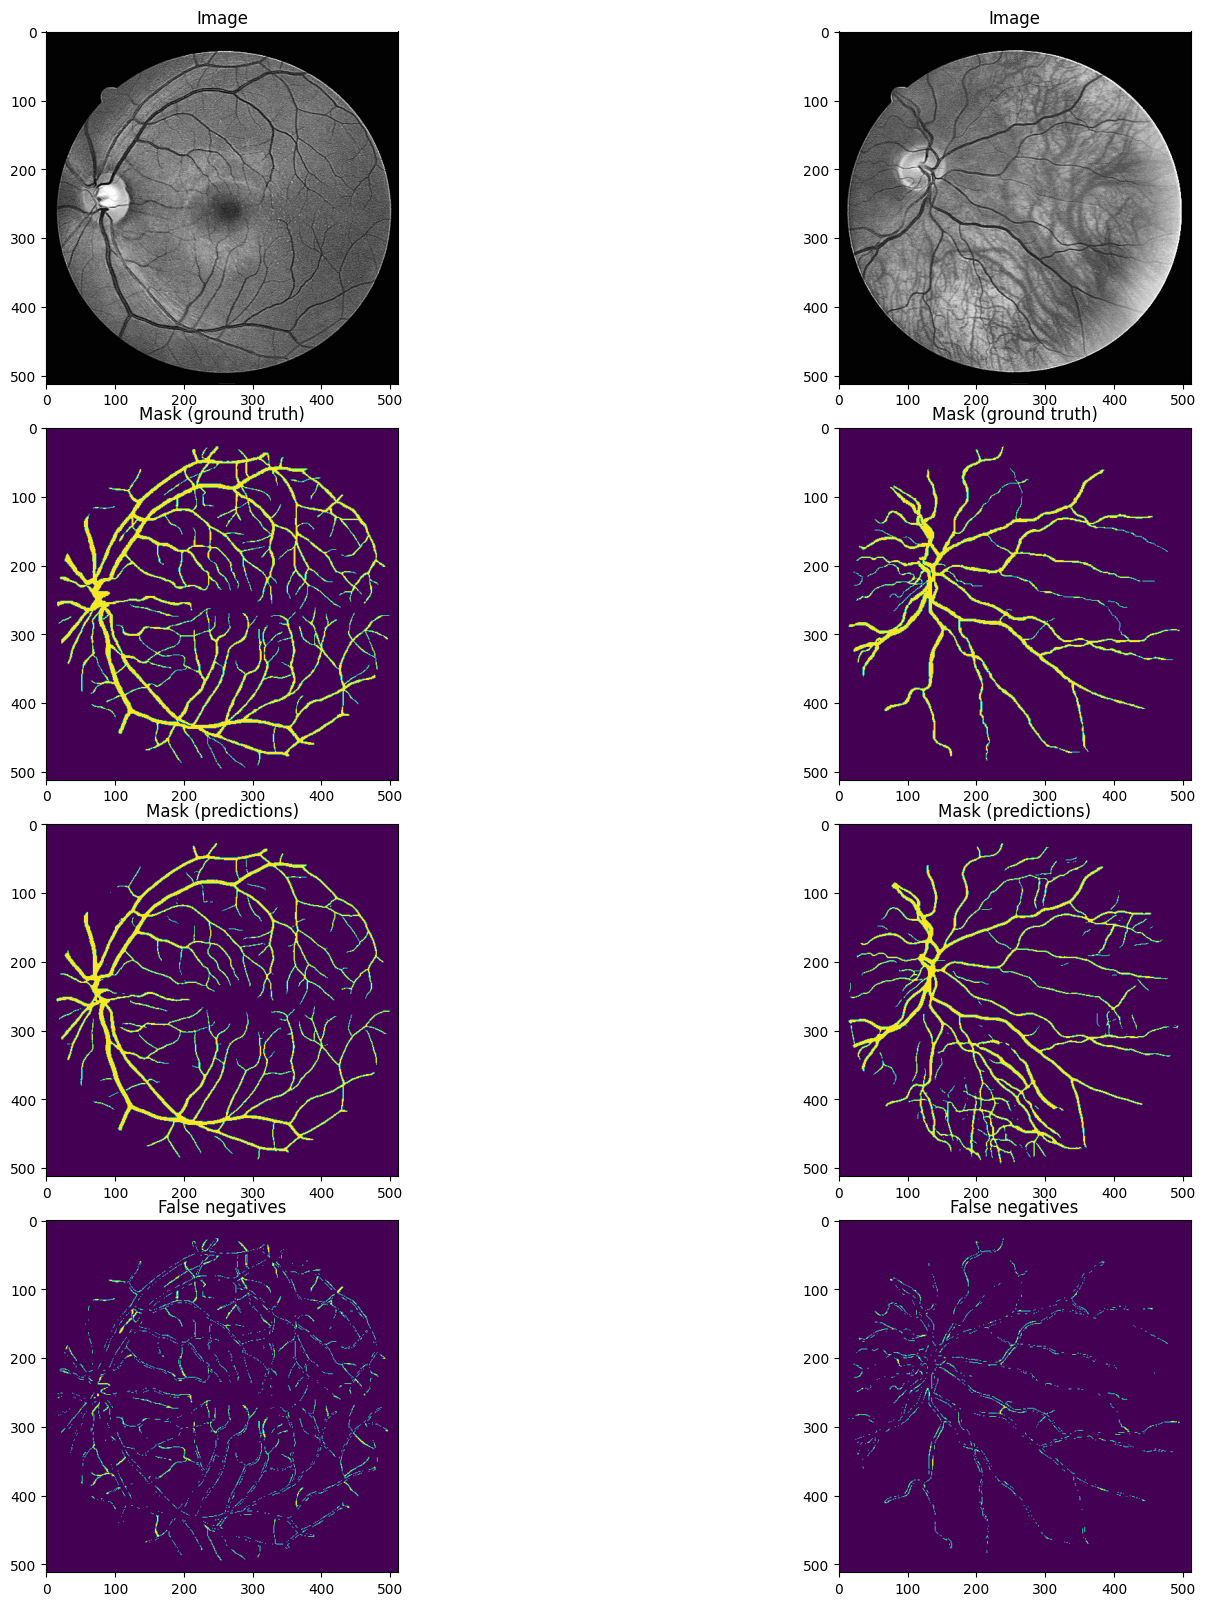

In [ ]:
#Mostra dei risultati parziali, per avere una idea generale
def show_prediction(x, y, model, n=2):
  fig, axs = plt.subplots(4, n,figsize=(16,16))
  fig.tight_layout()
  img_indices = np.random.choice(len(x), n, replace=False)
  images = x[img_indices]
  masks = y[img_indices]
  for k in range(n):
    axs[0][k].set_title("Image")
    axs[0][k].imshow(images[k], cmap='gray')
    axs[1][k].set_title("Mask (ground truth)")
    mask = masks[k]
    mask = digitize(mask)
    axs[1][k].imshow(mask)
    axs[2][k].set_title("Mask (predictions)")
    y_pred = model.predict(np.expand_dims(images[k], axis=0))[0][0]
    y_pred = digitize(y_pred)
    axs[2][k].imshow(y_pred)
    axs[3][k].set_title("False negatives")
    missing = np.where(np.logical_and(np.expand_dims(mask, axis=-1) == 1, y_pred == 0), 1.0, 0)
    axs[3][k].imshow(missing)

  plt.show()

best_model = models.load_model(file_name,
                               custom_objects={
                                 'loss': custom_loss([dice_loss, iou_loss], [1, 1]),
                                 'IoU': IoU,
                                 'dice_coefficient': dice_coefficient})
show_prediction(x_test, y_test, best_model)

In [ ]:
#Valutazione del modello all'uscita (I risultati si riferiscono alle immagini a 512x512)
def evaluate_model(model, xt, yt, xte, yte):
  _, loss, _, _, _, rmse, mae, iou, dicecoef, _, _, _, _, _, _, _, _, _, _, _, _ = model.evaluate(xt, yt, batch_size=1)
  train_metrics = [loss, rmse, mae, iou, dicecoef]
  _, loss, _, _, _, rmse, mae, iou, dicecoef, _, _, _, _, _, _, _, _, _, _, _, _ = model.evaluate(xte, yte, batch_size=1)
  test_metrics = [loss, rmse, mae, iou, dicecoef]

  loss, rmse, mae, iou, dicecoef = train_metrics
  print("Train loss", loss)
  print("Train rmse", rmse, "(", round(255*rmse, 2), " avg pixel error)")
  print("Train mae", mae, "(", round(255*mae, 2), " avg pixel error)")
  #print("Train cossine similarity", cossim, "(", round(100*cossim, 2), " %)")
  print("Train iou", iou, "(", round(100*iou, 2), " %)")
  print("Train dice coefficient (F1 score)", dicecoef, "(", round(100*dicecoef, 2), " %)")
  print()
  loss, rmse, mae, iou, dicecoef = test_metrics
  print("Test loss", loss)
  print("Test rmse", rmse, "(", round(255*rmse, 2), " avg pixel error)")
  print("Test mae", mae, "(", round(255*mae, 2), " avg pixel error)")
  #print("Test cossine similarity", cossim, "(", round(100*cossim, 2), " %)")
  print("Test iou", iou, "(", round(100*iou, 2), " %)")
  print("Test dice coefficient (F1 score)", dicecoef , "(", round(100*dicecoef, 2), " %)")

evaluate_model(best_model, x_train, y_train, x_test, y_test)

80/80 [==============================] - 14s 172ms/step - loss: 2.5287 - head_conv_out_loss: 0.5995 - head_conv_out_1_loss: 0.6084 - head_conv_out_2_loss: 0.6257 - head_conv_out_3_loss: 0.6952 - head_conv_out_root_mean_squared_error: 0.1659 - head_conv_out_mean_absolute_error: 0.0383 - head_conv_out_IoU: 0.6525 - head_conv_out_dice_coefficient: 0.7888 - head_conv_out_1_root_mean_squared_error: 0.1645 - head_conv_out_1_mean_absolute_error: 0.0379 - head_conv_out_1_IoU: 0.6469 - head_conv_out_1_dice_coefficient: 0.7848 - head_conv_out_2_root_mean_squared_error: 0.1651 - head_conv_out_2_mean_absolute_error: 0.0383 - head_conv_out_2_IoU: 0.6359 - head_conv_out_2_dice_coefficient: 0.7767 - head_conv_out_3_root_mean_squared_error: 0.1722 - head_conv_out_3_mean_absolute_error: 0.0413 - head_conv_out_3_IoU: 0.5945 - head_conv_out_3_dice_coefficient: 0.7449
Train loss 0.25806501507759094
Train rmse 0.09746194630861282 ( 24.85  avg pixel error)
Train mae 0.012597373686730862 ( 3.21  avg pixel er